# RDS Homework 2 Template
## Spring 2024


In [25]:
!pip install shap

In [26]:
from __future__ import print_function

import shap
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.ensemble
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_20newsgroups
from collections import defaultdict
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Configs
np.random.seed(1)
shap.initjs()
sns.set_style("whitegrid")

plot_shap=True # NOTE: Turn False to disable shap plots as they can be slow to load

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Problem 3

### Part (A)

In [27]:
# Mark the categories of interest
categories = ['alt.atheism', 'soc.religion.christian']

# Fetch the data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

# Set outcome class names
class_names = ['atheism', 'christian']


In [28]:
# Initialize & fit tf-idf vectorizer
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(newsgroups_train.data)
X_test = vectorizer.transform(newsgroups_test.data)

y_train = newsgroups_train.target
y_test = newsgroups_test.target


In [29]:
# Train & fit the classifier
model_a = sklearn.linear_model.SGDClassifier(loss='log_loss', penalty='l2', random_state=1)
model_a.fit(X_train, y_train)


SGDClassifier(loss='log_loss', random_state=1)

In [30]:
sklearn.metrics.accuracy_score(model_a.predict(X_test), y_test)

0.9344490934449093

### Part (B)

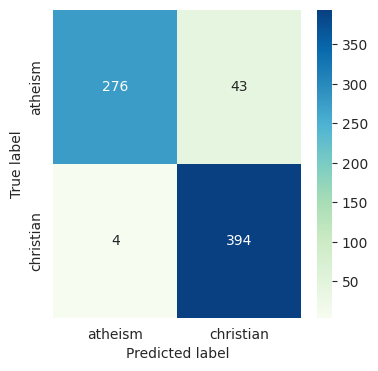

In [46]:
# Confusion Matrix
matrix = sklearn.metrics.confusion_matrix(y_test, model_a.predict(X_test))
plt.figure(figsize=(4,4))
sns.heatmap(matrix, annot=True, fmt="d",cmap="GnBu",xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [44]:
correct_christian = matrix[1,1]
incorrect_christian = matrix[1,0]
correct_atheism = matrix[0,0]
incorrect_atheism = matrix[0,1]
print("Correct Christianity:",correct_christian)
print("Incorrect Christianity:",incorrect_christian)
print("Correct Atheism:",correct_atheism)
print("Incorrect Atheism:",incorrect_atheism)

Correct Christianity: 394
Incorrect Christianity: 4
Correct Atheism: 276
Incorrect Atheism: 43


#### Explainer

In [32]:
# Initialize the explainer and apply to test data
explainer = shap.LinearExplainer(model_a, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [33]:
# Select 5 documents in the test set for explanation
# Choosing documents (include correctly classfied and misclassified documents)
#if y_pred == y_test, then correct
y_pred = model_a.predict(X_test)
correct_idx = np.where(y_test == y_pred)[0]
misclassified_idx = np.where(y_test != y_pred)[0]
show_correct = correct_idx[:3]
show_misclassified = misclassified_idx[3:5]
#combine five selected documnets
show_idx = np.concatenate((show_correct, show_misclassified))

In [34]:
# Visually explain 5 documents selected from the test set
X_test_array = X_test.toarray()
shap.initjs()
for idx in show_idx:
  actual_class = class_names[y_test[idx]]
  predicted_class = class_names[y_pred[idx]]
  print(f"Actual Class: {actual_class}")
  print(f"Predicted Class: {predicted_class}")
  shap_plot = shap.force_plot(
      explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
      feature_names=vectorizer.get_feature_names_out()
  )
  display(shap_plot)


Actual Class: christian
Predicted Class: christian


Actual Class: christian
Predicted Class: christian


Actual Class: atheism
Predicted Class: atheism


Actual Class: christian
Predicted Class: atheism


Actual Class: atheism
Predicted Class: christian


### Part (C)


#### Part (i)

In [35]:
# Compute the accuracy of the classifier and the number of misclassified documents
accuracy = sklearn.metrics.accuracy_score(y_pred, y_test)
print(f"The accuracy of this classifier is approximately {accuracy:.5f}")
#the number of misclassified documents should be 43+4, according to the confusion matrix
print(f"The number of misclassified documents is {len(misclassified_idx)}")

The accuracy of this classifier is approximately 0.93445
The number of misclassified documents is 47


#### Part (ii)

In [36]:
# Calculate conf_i for all misclassified documents

prob = model_a.predict_proba(X_test)
#print(prob)
#shows a 2D array, each array contain two number
#first one: prob of this document belong to class 0 (atheism)
conf_i = np.abs(prob[:,0] - prob[:,1])
mis_conf_i = conf_i[misclassified_idx]



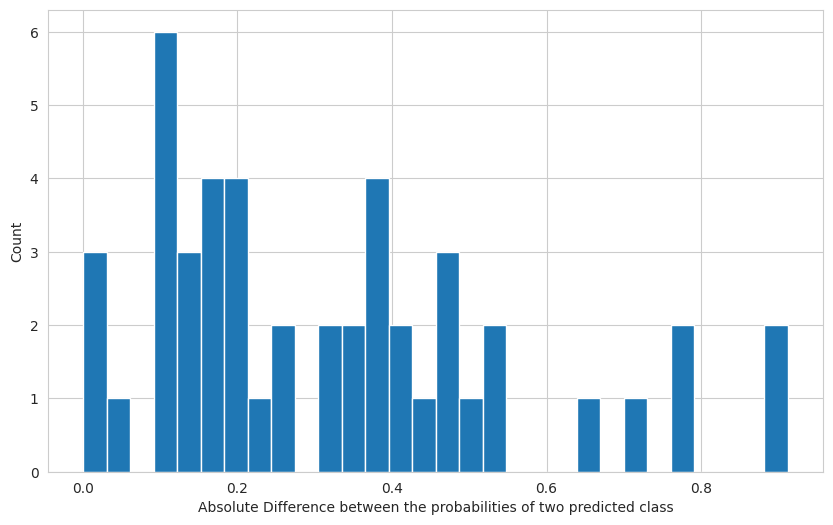

In [47]:
# Plot conf_i
plt.figure(figsize=(10,6))
plt.hist(mis_conf_i,bins=30)
plt.xlabel('Absolute Difference between the probabilities of two predicted class')
plt.ylabel('Count')
plt.show()

#### Part (iii)

In [38]:
#Identify tokens (word_j) that contributed to the misclassification of documents
#There are two interpretation for "word that contributed to the misclassification of documents"
#1. words that have a non-zero shap_val in the misclassfied document
#2. words that have the shap_val with same sign as the predicted class
#words with SHAP values that align with the (incorrect) predicted class are the ones contributing to the misclassification.
#e.g. if actual class:0 (Atheism); predicted class:1(Christianity)
#In this case, word with positive shap value will contribute to the misclassification of documents
# ?? We can't assume every word with shap_value in the same direction as predicted class, help misclassification
# ?? There could be some words indeed suggest the class of Christianity

word_dict = defaultdict(lambda: {'count': 0, 'weight': 0.0})
features = vectorizer.get_feature_names_out()

for idx in misclassified_idx:
  predicted_class = y_pred[idx]
  document_shap_val = shap_values[idx]
  for word, shap_val in zip(features, document_shap_val):
    if (predicted_class == 0 and shap_val < 0) or (predicted_class == 1 and shap_val > 0):
      word_dict[word]['count'] += 1
      word_dict[word]['weight'] += np.abs(shap_val)





dict_values([{'count': 39, 'weight': 0.2842664197921813}, {'count': 43, 'weight': 0.009526154034232936}, {'count': 43, 'weight': 0.005777279646843807}, {'count': 43, 'weight': 0.004442995432277033}, {'count': 43, 'weight': 0.006676915838784796}, {'count': 43, 'weight': 0.0032331497045767535}, {'count': 41, 'weight': 0.0026940548808800733}, {'count': 43, 'weight': 9.982106482170819e-05}, {'count': 43, 'weight': 9.982106482170819e-05}, {'count': 43, 'weight': 0.0027511583371509028}, {'count': 43, 'weight': 0.0019028305976747193}, {'count': 43, 'weight': 0.0007291572906362046}, {'count': 37, 'weight': 0.06568626428102078}, {'count': 43, 'weight': 0.0018579312112860541}, {'count': 43, 'weight': 0.012783707094919026}, {'count': 43, 'weight': 0.009526154034232936}, {'count': 43, 'weight': 0.002987113022707269}, {'count': 43, 'weight': 0.0009907226634806305}, {'count': 43, 'weight': 0.004110081411116717}, {'count': 43, 'weight': 0.0009907226634806305}, {'count': 43, 'weight': 0.00055135035944

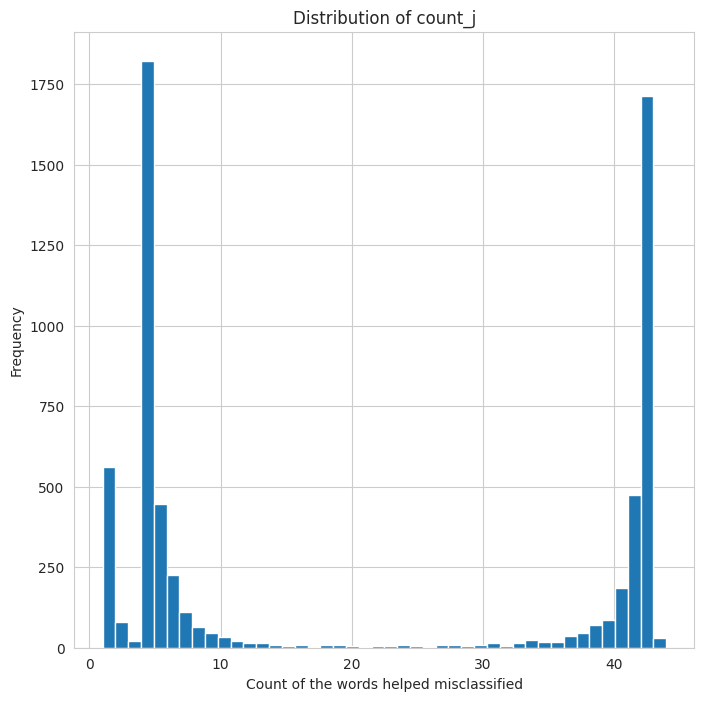

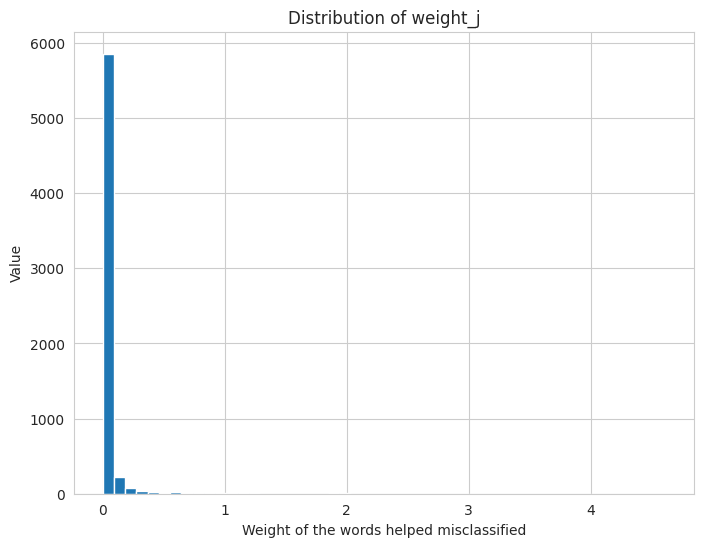

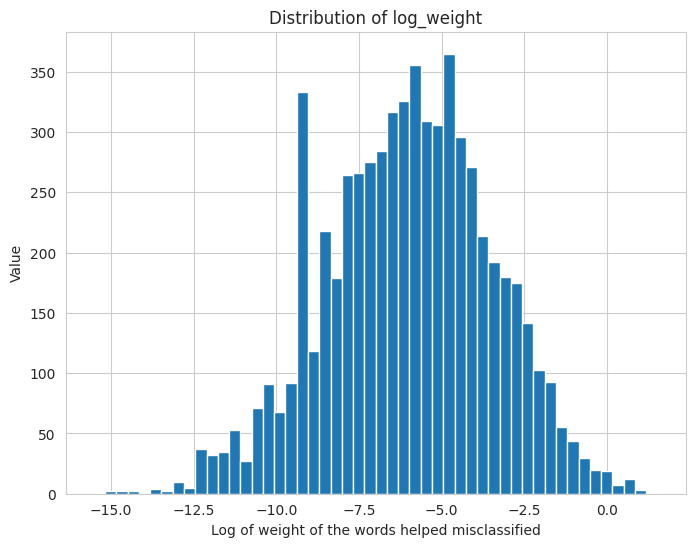

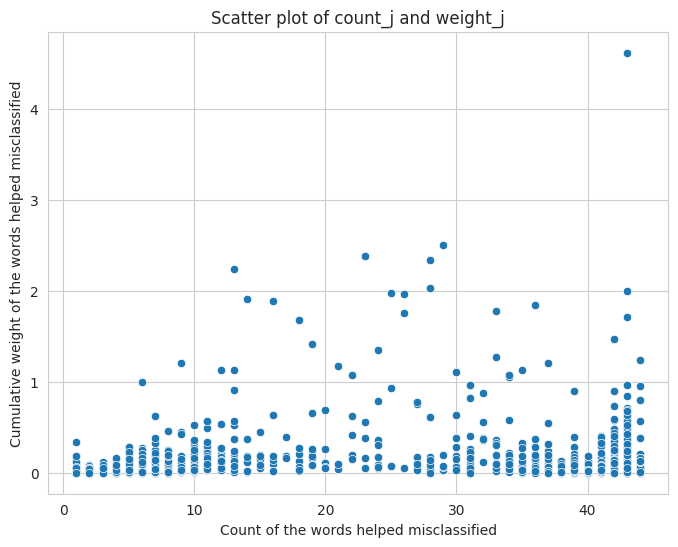

In [39]:
# Plot the distribution of count_j and weight_j
token = word_dict.keys()
count_weight = word_dict.values()
print(count_weight)
count_j = [word_dict[token]['count'] for token in token]
weight_j = [word_dict[token]['weight'] for token in token]

#plot for count_j
plt.figure(figsize=(8,8))
plt.hist(count_j, bins=max(count_j))
plt.xlabel('Count of the words helped misclassified')
plt.ylabel('Frequency')
plt.title('Distribution of count_j')
plt.show()

#plot for weight_j
#As the histogram shows that the distribution is extremely skewe, a box plot may be more informational in terms of illustraing the distribution
plt.figure(figsize=(8,6))
plt.hist(weight_j, bins =50)
plt.xlabel('Weight of the words helped misclassified')
plt.ylabel('Value')
plt.title('Distribution of weight_j')
plt.show()

#plot for log_weight
log_weight = np.log(weight_j)
plt.figure(figsize=(8,6))
plt.hist(log_weight, bins=50)
plt.xlabel('Log of weight of the words helped misclassified')
plt.ylabel('Value')
plt.title('Distribution of log_weight')
plt.show()

#To better show the distribution of count and weight, I use a scatterplot
plt.figure(figsize=(8,6))
sns.scatterplot(x=count_j, y=weight_j)
plt.xlabel('Count of the words helped misclassified')
plt.ylabel('Cumulative weight of the words helped misclassified')
plt.title('Scatter plot of count_j and weight_j')
plt.show()





### Part (D)

In [50]:
# Implement a strategy for feature selection

# From the scatterplot, we can notice there are points densely distributed in low weight area (mostly below 1).
# And they are almost evenly distributed across differnet areas of counts.Maybe more aroudn count = 10 and around count =40;
# Can't think count and weight separately, they are associated. Think through four different combination
# Strategy: Focus on removing features with high count and low weight, the right corner ones
# They are more likely to be the noise in the misclassified documents
# Set threhold for count and weight
# Count >= ? and cumulative weight <0.5


import numpy as np
count_threshold = np.percentile(count_j,75)
weight_threshold = 0.5
remove_words = []
for token, value in word_dict.items():
  if value['count'] >= count_threshold and value['weight'] < weight_threshold:
    remove_words.append(token)
#filter out the removed feature and update the list
updated_feature = [word for word in features if word not in remove_words]
#print(len(updated_feature)+len(remove_words))
#print(len(features))
vectorizer_updated = TfidfVectorizer(vocabulary=updated_feature)
X_train_updated = vectorizer_updated.fit_transform(newsgroups_train.data)
X_test_updated = vectorizer_updated.transform(newsgroups_test.data)

#y_train and y_test remain the same
#fit the model
model_updated = sklearn.linear_model.SGDClassifier(loss="log_loss",penalty="l2",random_state=1)
model_updated.fit(X_train_updated, y_train)
score = sklearn.metrics.accuracy_score(model_updated.predict(X_test_updated), y_test)
print(score)




0.9497907949790795


In [41]:
# Identify at least one example that was misclassified before feature selection and that is classified correctly after feature selection
fixed_example_index = []
for index in misclassified_idx:
  actual_class= y_test[index]
  predicted_class = model_updated.predict(X_test_updated)[index]
  if actual_class == predicted_class:
    fixed_example_index.append(index)
#print(fixed_example_index)
#initialize expaliner and apply to test data
shap.initjs()
explainer_updated = shap.LinearExplainer(model_updated, X_train_updated, feature_perturbation="interventional")
shap_values_updated = explainer_updated.shap_values(X_test_updated)

# Visually explain 5 documents selected from the test set
X_test_array2 = X_test_updated.toarray()
# Pick the first one that has fixed
example1_idx = fixed_example_index[1]
#before
actual_class1 = class_names[y_test[example1_idx]]
predicted_class1 = class_names[y_pred[example1_idx]]
print(f"Actual Class: {actual_class1}")
print(f"Predicted Class: {predicted_class1}")
shap_plot_before1 = shap.force_plot(
      explainer.expected_value, shap_values[example1_idx,:], X_test_array[example1_idx,:],
      feature_names=vectorizer.get_feature_names_out()
  )
display(shap_plot_before1)

#after
actual_class2 = class_names[y_test[example1_idx]]
predicted_class2 = class_names[model_updated.predict(X_test_updated)[example1_idx]]
print(f"Actual Class: {actual_class2}")
print(f"Predicted Class: {predicted_class2}")
shap_plot_after1 = shap.force_plot(
      explainer_updated.expected_value, shap_values_updated[example1_idx,:], X_test_array2[example1_idx,:],
      feature_names=vectorizer_updated.get_feature_names_out()
  )
display(shap_plot_after1)

















/usr/local/lib/python3.10/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Actual Class: atheism
Predicted Class: christian


Actual Class: atheism
Predicted Class: atheism


In [42]:
# Pick the another one that has fixed
example10_idx = fixed_example_index[11]
#before
shap.initjs()
actual_class10 = class_names[y_test[example10_idx]]
predicted_class10 = class_names[y_pred[example10_idx]]
print(f"Actual Class: {actual_class10}")
print(f"Predicted Class: {predicted_class10}")
shap_plot_before10 = shap.force_plot(
      explainer.expected_value, shap_values[example10_idx,:], X_test_array[example10_idx,:],
      feature_names=vectorizer.get_feature_names_out()
  )
display(shap_plot_before10)

#after
actual_class11 = class_names[y_test[example10_idx]]
predicted_class11 = class_names[model_updated.predict(X_test_updated)[example10_idx]]
print(f"Actual Class: {actual_class11}")
print(f"Predicted Class: {predicted_class11}")
shap_plot_after11 = shap.force_plot(
      explainer_updated.expected_value, shap_values_updated[example10_idx,:], X_test_array2[example10_idx,:],
      feature_names=vectorizer_updated.get_feature_names_out()
  )
display(shap_plot_after11)

Actual Class: atheism
Predicted Class: christian


Actual Class: atheism
Predicted Class: atheism
